In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import math
from scipy import log
from scipy.optimize import curve_fit

In [2]:
data = pd.read_csv("loanStats3c.csv",encoding='ANSI',header=1)

B:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_u=data[['id','installment']]

In [4]:
data_u

,id,installment
0,36805548,321.08
1,38098114,336.64
2,37662224,260.20
3,37612354,319.08
4,37822187,326.53
...,...,...
235628,9199665,367.58
235629,NaN,NaN
235630,NaN,NaN
235631,Total amount funded in policy code 1: 3503840175,NaN


In [5]:
#删掉存在空值的行
data_u.dropna(axis=0, how='any', inplace=True)

B:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


B:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


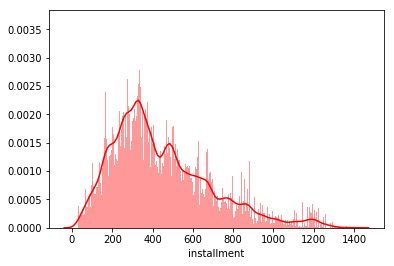

In [6]:
sns.distplot(data_u.installment,color="r",bins=500,kde=True,hist=True,rug=False)

In [7]:
data_u.installment.describe()

count    235629.000000
mean        442.487138
std         245.051601
min          23.360000
25%         265.680000
50%         384.120000
75%         578.770000
max        1409.990000
Name: installment, dtype: float64

In [8]:
#存在右边但不至于用指数函数设定组距，采用1000之前隔50为一组，1000之后100为一组，1300以后的一组
X_dot=[0]
for i in range(50,1000,50):
    X_dot.append(i)
for i in range(1000,1301,100):
    X_dot.append(i)
X_dot.append(max(data_u.installment))

In [9]:
# 数据放入组中
X_group = pd.cut(data_u.installment,bins=X_dot,right=True,retbins=False,include_lowest=False)

In [10]:
X_group

0         (300.0, 350.0]
1         (300.0, 350.0]
2         (250.0, 300.0]
3         (300.0, 350.0]
4         (300.0, 350.0]
               ...      
235624    (400.0, 450.0]
235625    (550.0, 600.0]
235626     (50.0, 100.0]
235627    (500.0, 550.0]
235628    (350.0, 400.0]
Name: installment, Length: 235629, dtype: category
Categories (24, interval[float64]): [(0.0, 50.0] < (50.0, 100.0] < (100.0, 150.0] < (150.0, 200.0] ... (1000.0, 1100.0] < (1100.0, 1200.0] < (1200.0, 1300.0] < (1300.0, 1409.99]]

In [11]:
# 计算总体的频率，利用groupby的方法
data=pd.DataFrame(data_u.installment)
data["group"]=X_group
groupValueSize=data.groupby(X_group).size()
pinshulist_T=list(pd.DataFrame(groupValueSize).reset_index().iloc[:,1])
pinlvlist_T=[i/len(data_u.installment) for i in pinshulist_T]

In [12]:
len(pinshulist_T),sum(pinshulist_T)#z总共有235629个数据被分为24组

(24, 235629)

In [13]:
samplenum=[100,500,1000,5000,10000]

In [14]:
#用于抽样的函数
def get_sample_jd(samplenum):
    pinshulist_sam=[]
    for i in samplenum:
        result = list(data_u.sample(i).installment)
        pinshulist_sam.append(result)
    return pinshulist_sam  
#计算样本质量Q的函数
def get_Q(get_sample_jd):
    pinlvlist_jd_all=[]
    for i in get_sample_jd(samplenum):
        X_group = pd.cut(i,bins=X_dot,right=True,retbins=False,include_lowest=False)
        data=pd.DataFrame(i)
        data["group"]=X_group
        groupValueSize=data.groupby(X_group).size()
        pinshulist_jd=list(pd.DataFrame(groupValueSize).reset_index().iloc[:,1])
        pinlvlist_jd = [j / len(X_group) for j in pinshulist_jd]
        pinlvlist_jd_all.append(pinlvlist_jd)
     #计算Q
    index_I = []
    for i in  pinlvlist_jd_all:
        I_per = sum((np.array(i)-np.array(pinlvlist_T))*np.log(np.array(i)/np.array(pinlvlist_T)+1e-5))#比值加上1e-5消除某组中没有抽到直接无穷大等的影响
        index_I.append(I_per)
        Q = np.exp(np.array(index_I)*(-1))
    return Q
   

In [15]:
#抽取50次
times=0
Q_meanpre=[]
while times < 50:
    get_sample_jd(samplenum)
    get_Q(get_sample_jd)
    Q_meanpre.append(get_Q(get_sample_jd))
    times=times+1


In [16]:
j_0=np.array(Q_meanpre)
arr1=np.zeros(5)
for i in np.arange(50):
    arr1 = (arr1+j_0[i])
arr=arr1/50

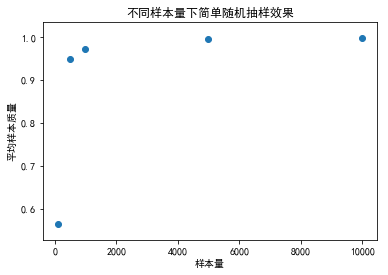

In [17]:
plt.scatter(samplenum,arr)
plt.xlabel('样本量')
plt.ylabel('平均样本质量')
plt.title('不同样本量下简单随机抽样效果')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [18]:
#取的样本量看不出样本质量0.9时的样本容量，故在50~1000之间按照多选取一些
#更新samplenum 再次计算
samplenum = np.arange(50,1001,50)

In [19]:
samplenum

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])

In [20]:
#抽取50次
times=0
Q_meanpre=[]
while times < 50:
    get_sample_jd(samplenum)
    get_Q(get_sample_jd)
    Q_meanpre.append(get_Q(get_sample_jd))
    times=times+1
j_0=np.array(Q_meanpre)
arr1=np.zeros(len(samplenum))
for i in np.arange(50):
    arr1 = (arr1+j_0[i])
arr=arr1/50


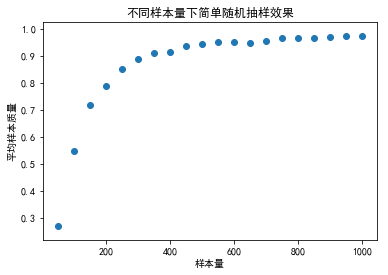

In [21]:
plt.scatter(samplenum,arr)
plt.xlabel('样本量')
plt.ylabel('平均样本质量')
plt.title('不同样本量下简单随机抽样效果')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [22]:
arr

array([0.26920106, 0.54792397, 0.71963201, 0.78956628, 0.85323641,
       0.88816985, 0.91288635, 0.91595543, 0.9372929 , 0.94451559,
       0.9510691 , 0.95300788, 0.94771356, 0.95641955, 0.96521117,
       0.96589016, 0.96698704, 0.9700827 , 0.97320307, 0.97495456])

In [36]:
#多项式拟合
n_order = 2        #阶数

x1 = samplenum
y1 = arr
p = np.poly1d(np.polyfit(x1,y1,n_order))            #拟合并构造出一个3次多项式
print(p.coeffs)                               #输出拟合的系数，顺序从高阶低阶


[-1.26147631e-06  1.76292721e-03  3.97163773e-01]


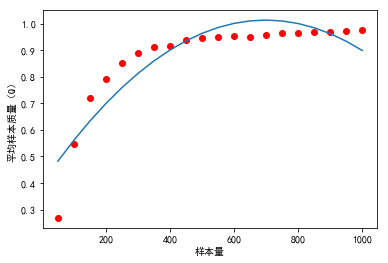

In [37]:
#画出拟合出来的多项式所表达的曲线以及原始的点
plt.plot(x1,y1,'ro',x1,p(x1),'-')
plt.xlabel('样本量')
plt.ylabel('平均样本质量（Q）')
plt.show()



In [35]:
pd.DataFrame(x1,p(x1))#二项400

,0
0.363993,50
0.517308,100
0.643585,150
0.745263,200
0.824781,250
0.884578,300
0.927092,350
0.954763,400
0.970030,450
0.975331,500


In [26]:
#对数拟合
from scipy import log
from scipy.optimize import curve_fit

def func(x, a, b):
    y = a * log(x) + b
    return y

def polyfit(x, y, degree):
    results = {}
    #coeffs = numpy.polyfit(x, y, degree)
    popt, pcov = curve_fit(func, x, y)
    results['polynomial'] = popt

    # r-squared
    yhat = func(x ,popt[0] ,popt[1] )                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results


In [27]:
x=samplenum[:9]
y=arr[:9]
z1 = polyfit(x, y, 2)
print (z1)
#determinatiom是R方 判决系数


{'polynomial': array([ 0.30188926, -0.85109439]), 'determination': 0.9607253647714622}


In [28]:
pre = 0.30609543 * log(x) +  -0.87048572

In [29]:
x

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])

In [30]:
pre

array([0.32696664, 0.53913583, 0.66324684, 0.75130501, 0.81960823,
       0.87541603, 0.92260085, 0.9634742 , 0.99952705])

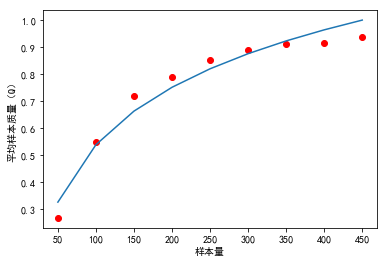

In [31]:
plt.plot(x,y,'ro',x,pre,'-')
plt.xlabel('样本量')
plt.ylabel('平均样本质量（Q）')
plt.show()

In [32]:
pd.DataFrame(x,pre) 

,0
0.326967,50
0.539136,100
0.663247,150
0.751305,200
0.819608,250
0.875416,300
0.922601,350
0.963474,400
0.999527,450
